# Libs

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import warnings
from sklearn.impute import KNNImputer
warnings.filterwarnings("ignore", category=FutureWarning)

# Introducción

La optimización de la producción agrícola es un pilar fundamental para la sostenibilidad y competitividad del sector agroindustrial. Para el Ingenio La Providencia, la variabilidad en el rendimiento de la caña por hectárea (TCH) y en la calidad de la materia prima (medida por el % de sacarosa) representa un desafío constante en la planificación de sus operaciones. Esta incertidumbre puede afectar directamente la logística de la cosecha, la eficiencia de los procesos en planta y, en última instancia, la rentabilidad del negocio.

El presente proyecto aborda este desafío mediante la aplicación de técnicas de machine learning sobre los datos históricos del ingenio. El objetivo principal es desarrollar modelos predictivos capaces de estimar con precisión dos indicadores críticos:

1.  **Las Toneladas de Caña por Hectárea (TCH)**, para anticipar el volumen de producción.
2.  **El Porcentaje de Sacarosa (%Sac.Caña)**, para prever la calidad y el potencial de azúcar extraíble.

Adicionalmente, se busca crear un sistema de clasificación que categorice el desempeño de los cultivos en niveles **alto, medio y bajo** para ambas variables. La implementación exitosa de estos modelos permitirá al Ingenio La Providencia pasar de una toma de decisiones reactiva a una estrategia proactiva, optimizando la gestión de recursos, mejorando la planificación de la zafra y maximizando tanto la productividad como la calidad de su producción.

Los datos provenientes de la base de datos **`HISTORICO_SUERTES.xlsx`** conforman un registro detallado de las operaciones agrícolas y los resultados de producción del Ingenio La Providencia. Se presume que cada fila representa un evento de cosecha para una "suerte" (lote de cultivo) específica. El conjunto de variables puede interpretarse y agruparse en las siguientes categorías funcionales:

### 1. Variables de Identificación y Agronómicas Fundamentales
Este grupo de variables permite identificar de manera única cada lote y describe sus características físicas y de cultivo.
* **Identificadores:** `Hacienda`, `Nombre` y `Suerte` funcionan como el identificador único de cada parcela. `Zona` y `Dist Km` la sitúan geográficamente y establecen su distancia a la planta, un factor logístico clave.
* **Características del Cultivo:** `Area Neta` define la superficie productiva del lote. Variables como `Suelo`, `Variedad`, `F.Siembra`, y `Cod.Estado` (que indica el número de corte, ej. "Plantilla" para la primera siembra o "Corte 2" para la segunda cosecha) son fundamentales, ya que definen el potencial genético y el ciclo de vida del cultivo.

### 2. Variables de Manejo y Prácticas Agrícolas
Aquí se registran las intervenciones humanas y las decisiones de manejo que influyen directamente en el desarrollo y la maduración de la caña.
* **Labores Culturales:** Se documentan prácticas clave como el riego (`Num.Riegos`, `M3 Riego`, `Ult.Riego`), la fertilización (`Fert.Nitrogen.`, `Urea 46%`, `Vinaza`) y el uso de madurantes químicos (`Producto`, `Dosis Madurante`), que son palancas críticas para optimizar el rendimiento.
* **Cosecha:** Variables como `Tipo Quema` (verde o quemada) y `T.Corte` (mecanizado o manual) describen el método de cosecha, el cual tiene un impacto directo en la calidad de la materia prima que llega al ingenio.

### 3. Variables de Producción y Calidad (Variables Objetivo)
Este es el grupo más importante, ya que contiene los indicadores de desempeño que se busca predecir.
* **Productividad:** La variable principal es **`TCH` (Toneladas de Caña por Hectárea)**, que mide el rendimiento agrícola del lote. Está directamente relacionada con `TonUltCorte`, que es la producción total en toneladas.
* **Calidad:** La variable clave de calidad es **`%Sac.Caña`**, que representa el porcentaje de sacarosa en la caña y determina su valor para la producción de azúcar. Se complementa con otras métricas como `Rdto` (Rendimiento industrial) y `%ATR` (Azúcares Totales Recuperables), que también reflejan la eficiencia en la extracción de azúcar.

### 4. Variables Climáticas y Ambientales
El desempeño de un cultivo depende en gran medida del entorno. Este grupo de variables busca capturar esas condiciones.
* **Clima:** Se registran datos meteorológicos cruciales como `Lluvias`, `Temp. Media`, `Humedad Rel Media` y `Radiacion Solar`. Es notable que estas variables están agregadas en diferentes ventanas de tiempo (ej. `0-3 meses`, `Ciclo completo`), lo que permite analizar cómo las condiciones climáticas en distintas etapas fenológicas del cultivo afectan el resultado final.
* **Sanidad:** La variable `%Infest.Diatrea` es un indicador de la salud del cultivo, midiendo el impacto de una de las plagas más significativas de la caña de azúcar.

La base de datos **`BD_IPSA_1940.xlsx`** proporciona un conjunto de variables consolidadas, orientadas a la tarea de clasificación del desempeño de los lotes. A diferencia del set de datos históricos para regresión, este parece estar más enfocado en factores agronómicos clave y los resultados finales de cosecha. Cada fila representa un evento de cosecha para una variedad específica, CC01-1940.

Las variables presentes pueden agruparse e interpretarse de la siguiente manera:

### 1. Variables de Identificación y Características del Cultivo
Este grupo de variables permite identificar el lote y define sus condiciones agronómicas básicas.
* **Identificadores:** `NOME`, `FAZ` (Hacienda) y `TAL` (Talhão o Suerte) identifican la unidad productiva específica.
* **Características Agronómicas:** `variedad` especifica el tipo de caña. `tipocorte` describe el método de cosecha. `cortes` indica el número de cosechas que ha tenido la planta (su ciclo de soca), y `edad` representa la edad del cultivo en meses al momento del corte, dos factores determinantes en la productividad.

### 2. Variables de Manejo de Maduración
Un conjunto de variables está dedicado exclusivamente a la práctica de maduración química, sugiriendo su importancia como factor predictivo.
* `madurada`: Es una variable categórica (SI/NO) que indica si se aplicó o no un producto para inducir la maduración.
* `producto`, `dosismad` (Dosis del Madurante) y `semsmad` (Semanas desde la aplicación hasta la cosecha): Detallan el tipo de madurante utilizado, la cantidad y el tiempo de acción, lo que permite evaluar la efectividad de esta práctica agrícola.

### 3. Indicadores de Desempeño y Calidad (Variables a Clasificar)
Estas son las variables centrales del problema. A partir de ellas se construirán las categorías de "alto", "medio" y "bajo" rendimiento.
* **Variables Objetivo (Continuas):** **`TCH` (Toneladas de Caña por Hectárea)** y **`sacarosa` (%)** son los indicadores directos de la productividad agrícola y la calidad industrial, respectivamente. Estos valores serán la base para crear las etiquetas de clasificación.
* **Indicadores Adicionales:** `pct_diatrea` (% de infestación de Diatraea) y `me` (probablemente Materia Extraña) son métricas que reflejan la sanidad y limpieza del cultivo, factores que impactan negativamente tanto el TCH como la sacarosa. `vejez` Aunque el diccionario lo define como "antigüedad" del cultivo, en el contexto de la calidad industrial, esta variable probablemente se refiera al tiempo transcurrido (en horas o días) entre el corte y la molienda, un factor crítico para la calidad de la sacarosa.

### 4. Variables de Contexto Temporal y Ambiental
Este grupo final de variables sitúa cada cosecha en un contexto específico.
* `mes` y `periodo`: Definen el momento exacto de la cosecha, permitiendo analizar la estacionalidad.
* `lluvias`: Es una variable climática fundamental que resume las precipitaciones acumuladas en un periodo relevante para la cosecha.
* `grupo_tenencia`: Es una variable categórica que probablemente se refiere al tipo de propiedad o administración del lote (ej. propio, arrendado), lo cual puede implicar diferencias en las estrategias de manejo.

# Análisis Exploratorio de Datos (EDA)

In [2]:
# Opción para ver TODAS las filas (None significa sin límite)
pd.set_option('display.max_rows', None)

# Opción para ver TODAS las columnas (None significa sin límite)
pd.set_option('display.max_columns', None)

# Opción para aumentar el ancho de la línea y evitar que se corte la tabla
pd.set_option('display.width', 1000)

In [3]:
file_name = 'data/HISTORICO_SUERTES.xlsx'

df = pd.read_excel(file_name)

df.head(3)

,Período,Hacienda,Nombre,Zona,Tenencia,Suerte,Suelo,Area Neta,Dist Km,Variedad,Cod.Estado #,Cod.Estado,F.Siembra,D.S.,Ult.Riego,Edad Ult Cos,F.Ult.Corte,Destino 1=Semilla,Cod. T.Cultivo,Cultivo,Fec.Madur.,Producto,Dosis Madurante,Semanas mad.,TonUltCorte,TCH,TCHM,Ton.Azucar,Rdto,TAH,TAHM,Sac.Caña Precosecha,Edad.Precosecha,%Sac.Caña,%Sac.Muestreadora,%ATR,KATRHM,%Fibra Caña,%AR Jugo,%ME Min,%ME Veg,%ME Tot,Brix,Pureza,Vejez,Tipo Quema,T.Corte,Cerca de,Cosechó,Num.Riegos,M3 Riego,DDUlt.Riego,Lluvias (2 Meses Ant.),Lluvias Ciclo,Lluvias 0 -3,Lluvias tres a seis,Lluvias seis a nueve,Luvias 9 -FC,%Infest.Diatrea,Fosfato Jugo,Fert.Nitrogen.,Urea 46%,MEZ,Boro Granul.,MicroZinc,NITO_XTEND,Sul.Amonio,NITRAX-S,Vinaza,Codigo Estacion,Temp. Media 0-3,Temp. Media Ciclo,Temp Max Ciclo,Temp Min Ciclo,Humedad Rel Media 0-3,Humedad Rel Media Ciclo,Oscilacion Temp Med 0-3,Oscilacion Temp Ciclo,Sum Oscilacion Temp Ciclo,Radicion Solar 0-3,Radiacion Solar Ciclo,Precipitacion 0_3,Precipitacion Ciclo,Evaporacion 0-3,Evaporacion Ciclo
0,201701,80493,LA CONCHA,IP02,51.0,002A,CANTARINA,6.00,4.3,CC85-92,5,Corte 5,2010-08-20,NaN,NaT,12.81,2017-01-02,0,1.0,Normal,2016-11-04,BONUS 250 EC REGULADOR FISIOLÓGICO,1.0,8.428571,727.19,121.198333,9.461228,86.050,11.8332,14.341666,1.119567,16.8172,NaN,13.7582,13.508,15.1653,1434.823641,16.910,0.84,0.355,10.198,10.553,15.7464,87.2241,2.735,VERDE,MECANIZADO,El Cerrito,AI08,NaN,0.0,0,258.0,1038.0,0.0,454.0,102.0,482.0,NaN,178.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,201701,81284,UKRANIA INCAUCA,IP05,81.0,039B,NaN,1.45,NaN,CC85-92,5,Corte 5,2011-01-27,NaN,NaT,11.14,2017-01-02,0,1.0,Normal,NaT,NaN,0.0,NaN,136.00,93.793103,8.419488,14.728,10.8294,10.157241,0.911781,NaN,NaN,12.8430,12.551,14.0410,1182.180399,16.936,0.55,2.298,7.273,9.571,15.2240,84.3602,73.823,Q.ACCIDENTAL,MANUAL,Candelaria,AI08,NaN,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,382.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,201701,80203,EL AMPARO SAA,IP05,31.0,007,CORINTIAS,8.24,23.0,CC01-1228,4,Corte 4,2011-10-25,1.65,2016-09-17,12.32,2017-01-02,0,1.0,Normal,2016-11-04,BONUS 250 EC REGULADOR FISIOLÓGICO,1.1,8.428571,1436.62,174.347087,14.151549,145.268,10.1117,17.629611,1.430974,14.7749,12.02,11.9364,11.940,13.1236,1857.192723,15.512,0.61,3.000,9.323,12.323,14.1130,84.4527,2.108,VERDE,MECANIZADO,Palmira,AI08,5.0,48513.6,107,246.0,1002.0,106.0,326.0,113.0,457.0,NaN,226.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
df.describe()

,Período,Hacienda,Tenencia,Area Neta,Dist Km,Cod.Estado #,Edad Ult Cos,Destino 1=Semilla,Cod. T.Cultivo,Dosis Madurante,Semanas mad.,TonUltCorte,TCH,TCHM,Ton.Azucar,Rdto,TAH,TAHM,Sac.Caña Precosecha,Edad.Precosecha,%Sac.Caña,%Sac.Muestreadora,%ATR,KATRHM,%Fibra Caña,%AR Jugo,%ME Min,%ME Veg,%ME Tot,Brix,Pureza,Vejez,Num.Riegos,M3 Riego,DDUlt.Riego,Lluvias (2 Meses Ant.),Lluvias Ciclo,Lluvias 0 -3,Lluvias tres a seis,Lluvias seis a nueve,Luvias 9 -FC,%Infest.Diatrea,Fosfato Jugo,Fert.Nitrogen.,Urea 46%,MEZ,Boro Granul.,MicroZinc,NITO_XTEND,Sul.Amonio,NITRAX-S,Vinaza,Temp. Media 0-3,Temp. Media Ciclo,Temp Max Ciclo,Temp Min Ciclo,Humedad Rel Media 0-3,Humedad Rel Media Ciclo,Oscilacion Temp Med 0-3,Oscilacion Temp Ciclo,Sum Oscilacion Temp Ciclo,Radicion Solar 0-3,Radiacion Solar Ciclo,Precipitacion 0_3,Precipitacion Ciclo,Evaporacion 0-3,Evaporacion Ciclo
count,21027.000000,21027.000000,21026.000000,21027.000000,21022.000000,21027.000000,21027.00000,21027.000000,21025.000000,20923.000000,11252.000000,21027.000000,21027.000000,21027.000000,20786.000000,20760.000000,20786.000000,20786.000000,19929.000000,8919.000000,20578.000000,19169.000000,20505.000000,20505.000000,19169.000000,18903.000000,19305.00000,19307.000000,19307.000000,20760.000000,20758.000000,18582.000000,8438.000000,21027.000000,21027.000000,21027.000000,21027.000000,21027.000000,21027.000000,21027.000000,21027.000000,5600.000000,19169.000000,0.0,7.230000e+02,971.000000,1285.000000,1149.000000,3679.000000,1357.000000,748.000000,4098.000000,4530.000000,4530.000000,4530.000000,4530.000000,4530.000000,4530.000000,4530.000000,4530.000000,0.0,4530.000000,4530.000000,4530.000000,4530.000000,4530.000000,4530.000000
mean,202039.708708,80679.334427,46.448730,8.642948,25.311806,4.261806,13.01111,0.013982,1.036100,0.536335,9.588708,1141.737477,129.608509,10.050417,124.249246,10.733766,13.888988,1.071335,7.802876,12.360247,12.320202,12.834918,13.718671,1372.453892,15.275538,0.737819,0.63653,7.761020,8.600761,13.130479,77.805153,12.294125,7.215691,25725.851363,45.997717,75.116456,526.176110,122.333534,120.193700,118.080529,165.606631,3.811395,332.501252,NaN,1.848838e+04,481.805869,118.158210,128.934639,2360.857856,2447.356346,1530.278591,74481.323472,23.375724,24.556072,34.587837,15.416313,81.176861,80.764679,16.059757,24.556072,NaN,435.119397,438.344500,298.258587,1209.462980,442.941369,1912.479868
std,216.642895,590.030150,21.513498,7.049533,18.237344,4.111935,1.97907,0.117419,0.186543,0.539796,5.585010,1018.073158,32.846029,2.502829,111.842688,1.517069,3.805457,0.284829,8.507614,1.420836,1.145738,2.001026,1.451582,341.453701,2.493603,0.238630,0.95059,3.108904,2.482570,4.238401,24.487124,20.993880,16.276732,57539.237598,76.510120,98.054033,551.550097,145.134130,144.103575,141.096477,233.114931,2.820273,1605.182193,NaN,4.579260e+05,542.391407,112.947454,110.225440,2855.789893,2342.687825,1469.082903,69189.671641,1.254361,2.471964,0.984804,0.487640,2.848861,2.752029,1.300131,2.471964,NaN,21.307392,18.582606,102.901635,340.463189,43.680452,307.978328
min,201701.000000,80100.000000,11.000000,0.004000,1.100000,0.000000,1.31000,0.000000,1.000000,0.000000,-2.000000,0.420000,1.573653,0.138403,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.086000,0.000000,7.750000,49.089172,0.000000,0.100000,0.00000,0.000000,0.200000,0.000000,0.000000,0.017000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,1.900000e+01,1.000000,1.000000,1.000000,33.000000,7.000000,1.300000,5.921000,22.040000,22.353000,32.600000,13.900000,60.341000,63.327000,12.500000,22.353000,NaN,352.013000,367.315000,23.100000,23.100000,190.400000,190.400000
25%,201812.000000,80247.000000,31.000000,3.310000,12.000000,1.000000,11.93000,0.000000,1.000000,0.000000,6.571428,398.442500,108.691426,8.463211,42.282500,10.117175,11.690238,0.909263,0.000000,11.530000,11.619000,12.148700,13.015800,1165.486757,14.327400,0.568600,0.12100,6.786150,7.431900,13.470875,83.517250,2.10800

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21027 entries, 0 to 21026
Data columns (total 85 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   Período                    21027 non-null  int64         
 1   Hacienda                   21027 non-null  int64         
 2   Nombre                     21027 non-null  object        
 3   Zona                       21027 non-null  object        
 4   Tenencia                   21026 non-null  float64       
 5   Suerte                     21027 non-null  object        
 6   Suelo                      17269 non-null  object        
 7   Area Neta                  21027 non-null  float64       
 8   Dist Km                    21022 non-null  float64       
 9   Variedad                   21027 non-null  object        
 10  Cod.Estado #               21027 non-null  int64         
 11  Cod.Estado                 21027 non-null  object        
 12  F.Si

# Preparación y análisis de datos

Shape antes de eliminar: (21027, 85)
Shape después de eliminar: (20578, 85)


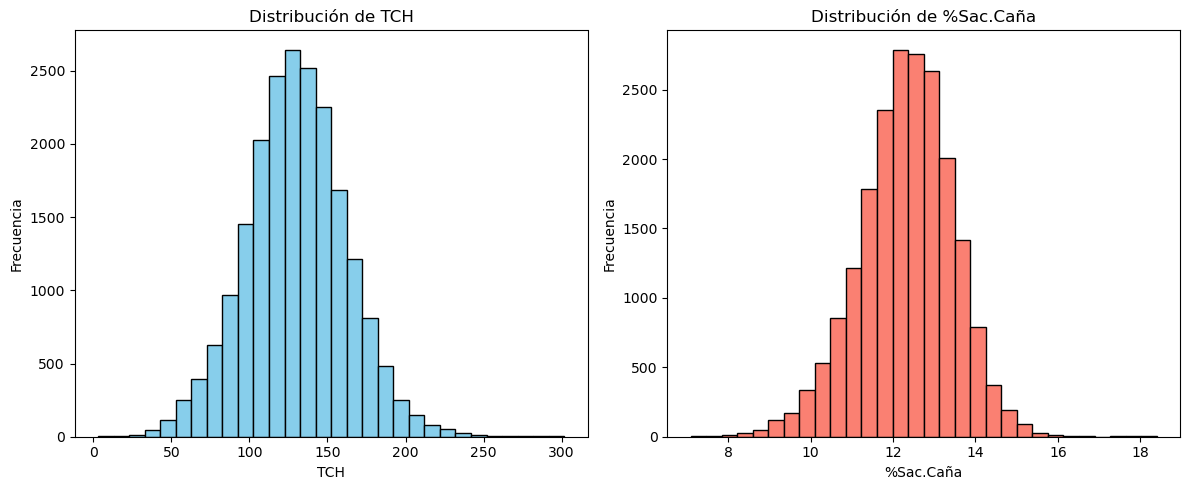

In [6]:
print("Shape antes de eliminar:", df.shape)
df = df.dropna(subset=['TCH', '%Sac.Caña']) # Eliminamos las que no tengan las variables objetivos
print("Shape después de eliminar:", df.shape)

# Mostrar las distribuciones de las variables objetivo
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].hist(df['TCH'], bins=30, color='skyblue', edgecolor='black')
axes[0].set_title('Distribución de TCH')
axes[0].set_xlabel('TCH')
axes[0].set_ylabel('Frecuencia')

axes[1].hist(df['%Sac.Caña'], bins=30, color='salmon', edgecolor='black')
axes[1].set_title('Distribución de %Sac.Caña')
axes[1].set_xlabel('%Sac.Caña')
axes[1].set_ylabel('Frecuencia')

plt.tight_layout()
plt.show()

Luego de la reunión con Paula del ingenio descubrimos que los datos con tch>250 y txh<50 son atipicos y deben eliminarse.

In [7]:
df = df[(df['TCH'] <= 250) & (df['TCH'] >= 50)]

In [8]:
# 1. Identifica las variables o columnas en el dataset con valores nulos
columnas_con_nulos = [
    (columna, df[columna].isnull().sum())
    for columna in df.columns
    if df[columna].isnull().sum() > 0
]
# 2. Convertir la lista a un DataFrame de pandas para una mejor visualización
df_nulos = pd.DataFrame(columnas_con_nulos, columns=['Columna', 'Cantidad de Nulos'])

# Ordenar los resultados de mayor a menor
df_nulos_ordenado = df_nulos.sort_values(by='Cantidad de Nulos', ascending=False)


# Imprimir el DataFrame resultante
print("\nResultados en una tabla ordenada de mayor a menor:")
df_nulos_ordenado


Resultados en una tabla ordenada de mayor a menor:


,Columna,Cantidad de Nulos
27,Fert.Nitrogen.,20406
45,Sum Oscilacion Temp Ciclo,20406
28,Urea 46%,19703
34,NITRAX-S,19676
29,MEZ,19488
31,MicroZinc,19304
30,Boro Granul.,19190
33,Sul.Amonio,19101
32,NITO_XTEND,16921
35,Vinaza,16502


Registros con TODAS las variables climáticas nulas: 16072

Resumen de registros sin datos climáticos por Período:
         Total registros  Registros sin datos climáticos  % sin datos climáticos
Período                                                                         
201701               226                             226              100.000000
201702               119                             119              100.000000
201703               167                             167              100.000000
201704               183                             183              100.000000
201705               147                             147              100.000000
201706               228                             228              100.000000
201707               201                             201              100.000000
201708               212                             212              100.000000
201709               229                             229              100.00

,TCH,%Sac.Caña
Evaporacion Ciclo,0.229442,0.132865
Evaporacion 0-3,0.197958,-0.074752
Radiacion Solar 0-3,0.162994,-0.047351
Radiacion Solar Ciclo,0.105656,0.051665
Oscilacion Temp Med 0-3,0.036555,-0.092157
Temp. Media 0-3,0.019227,-0.123482
Humedad Rel Media Ciclo,0.006454,-0.077885
Precipitacion Ciclo,0.005371,-0.011756
Temp Max Ciclo,-0.023841,-0.015618
Temp. Media Ciclo,-0.053917,-0.047934


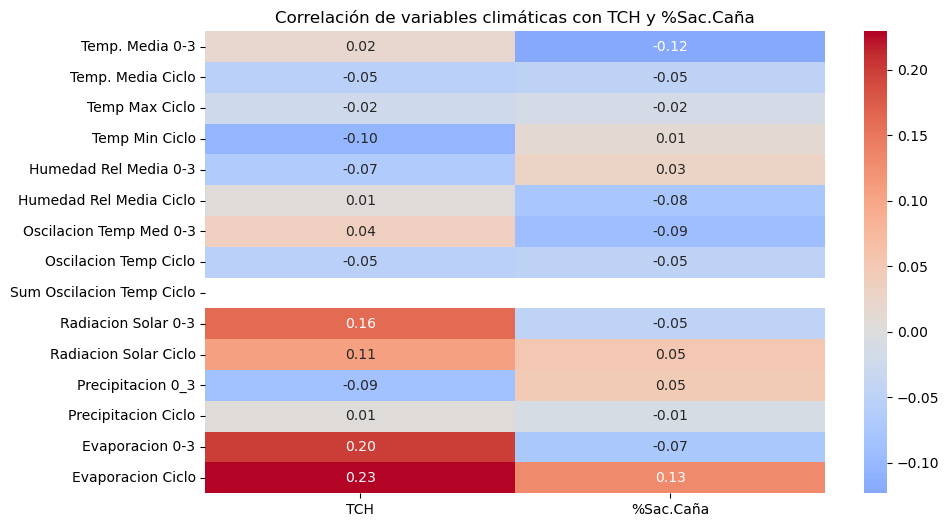

In [9]:
# =====================================================
# 0) Renombrar columnas mal escritas o con espacios
# =====================================================
df = df.rename(columns={
    "Humedad Rel Media 0-3 ": "Humedad Rel Media 0-3",  # quitar espacio final
    "Radicion Solar 0-3": "Radiacion Solar 0-3"         # corregir error ortográfico
})

# =====================================================
# 1) Variables climáticas corregidas
# =====================================================
vars_climaticas = [
    "Temp. Media 0-3",
    "Temp. Media Ciclo",
    "Temp Max Ciclo",
    "Temp Min Ciclo",
    "Humedad Rel Media 0-3",
    "Humedad Rel Media Ciclo",
    "Oscilacion Temp Med 0-3",
    "Oscilacion Temp Ciclo",
    "Sum Oscilacion Temp Ciclo",
    "Radiacion Solar 0-3",
    "Radiacion Solar Ciclo",
    "Precipitacion 0_3",
    "Precipitacion Ciclo",
    "Evaporacion 0-3",
    "Evaporacion Ciclo"
]

# =====================================================
# 2) Análisis de valores faltantes
# =====================================================
df_clima_nulos = df[vars_climaticas].isnull().sum(axis=1)
print(f"Registros con TODAS las variables climáticas nulas: {(df_clima_nulos == len(vars_climaticas)).sum()}")

# Relación de nulos por Período
clima_nulos_por_periodo = (
    df.assign(clima_nulos_totales=(df_clima_nulos == len(vars_climaticas)))
        .groupby("Período")["clima_nulos_totales"]
        .agg(["count", "sum"])
        .rename(columns={"count": "Total registros", "sum": "Registros sin datos climáticos"})
)
clima_nulos_por_periodo["% sin datos climáticos"] = (
    100 * clima_nulos_por_periodo["Registros sin datos climáticos"] / clima_nulos_por_periodo["Total registros"]
)
print("\nResumen de registros sin datos climáticos por Período:")
print(clima_nulos_por_periodo)

# =====================================================
# 3) Correlación de variables climáticas con objetivos
# =====================================================

corr_matrix = df[vars_climaticas + ["TCH", "%Sac.Caña"]].corr(method="pearson")

# Extraer solo filas de variables climáticas y columnas de objetivos
clima_corr = corr_matrix.loc[vars_climaticas, ["TCH", "%Sac.Caña"]]

print("\nCorrelación de variables climáticas con TCH y %Sac.Caña:")
display(clima_corr.sort_values("TCH", ascending=False))

# Heatmap
plt.figure(figsize=(10,6))
sns.heatmap(clima_corr, annot=True, cmap="coolwarm", center=0, fmt=".2f")
plt.title("Correlación de variables climáticas con TCH y %Sac.Caña")
plt.show()



In [10]:
# --- Corrección Específica para 'Producto' ---

# 1. Reemplazar la versión con acento por la versión sin acento para unificar la categoría.
#    Es buena práctica elegir una forma estándar (usualmente sin acentos y en mayúsculas/minúsculas).
df['Producto'] = df['Producto'].replace(
    'BONUS 250 EC REGULADOR FISIOLÓGICO', 
    'BONUS 250 EC REGULADOR FISIOLOGICO'
)

df['Zona'] = df['Zona'].replace(
    'ip05', 
    'IP05'
)



## **Análisis de Datos Faltantes e Irrelevantes junto con Estrategia de Mitigación**

Tras una revisión de la completitud de los datos para los **21,027 registros** del dataset, es evidente que existe un problema significativo de valores nulos que debe ser abordado antes de cualquier modelado. La estrategia para manejar estos datos se basará en el porcentaje de información faltante por columna, dividiendo el proceso en varias fases jerárquicas para asegurar la integridad y robustez del conjunto de datos final.



### Fase 1: Partición del dataset y reemplazo estrategico de valores nulos

El procesamiento inicial se centró en tres grupos de variables clave:

**Variables climáticas (`vars_climaticas`)**  
Incluyen temperatura, humedad, precipitación, radiación y evaporación en diferentes ventanas (0–3 meses y ciclo).  
- **Acción:** se mantienen sin imputación masiva, ya que son predictores fundamentales y la ausencia previa se debe a falta de cobertura de estaciones.  
- **Justificación:** solo se consideran períodos desde `202202`, donde ya no están completamente vacías. Como se pudo observar anteriormente, las variables climáticas tienen un alto impacto en las variables objetivo.

**Variables de insumos y madurantes (`vars_insumos`)**  
Comprenden dosis de fertilizantes y enmiendas aplicadas.  
- **Acción:** los valores nulos se reemplazan por **0**, interpretando que la ausencia de registro corresponde a **no aplicación**.  
- **Justificación:** evita inventar dosis ficticias y refleja la práctica de campo donde solo se consigna lo que efectivamente se aplicó.

**Variables de infestación (`vars_infest`)**  
Actualmente `%Infest.Diatrea`.  
- **Acción:** los nulos se reemplazan por **0**, entendiendo que la falta de registro corresponde a **no observada**.  
- **Justificación:** coherente con la forma en que se reportan plagas en bitácoras, donde se registra únicamente si hay presencia.

**Filtro temporal aplicado**  
- **Acción:** conservar únicamente registros con `Período ≥ 202202`.  
- **Justificación:** en los períodos previos el clima estaba 100% ausente, lo cual no aporta valor y puede sesgar el análisis.

**Resultado**  
Se obtiene un dataset depurado donde:  
- El clima se conserva a partir de 2022 con datos utilizables.  
- Los insumos y las infestaciones reflejan adecuadamente la ausencia como **0**.  
- Se evita sesgo por registros de períodos sin cobertura climática.


In [11]:
# ---------- 1) Listas de columnas ----------
vars_climaticas = [
    "Temp. Media 0-3","Temp. Media Ciclo","Temp Max Ciclo","Temp Min Ciclo",
    "Humedad Rel Media 0-3","Humedad Rel Media Ciclo",
    "Oscilacion Temp Med 0-3","Oscilacion Temp Ciclo","Sum Oscilacion Temp Ciclo",
    "Radiacion Solar 0-3","Radiacion Solar Ciclo",
    "Precipitacion 0_3","Precipitacion Ciclo",
    "Evaporacion 0-3","Evaporacion Ciclo"
]

# Insumos/madurantes: ceros = no aplicado
vars_insumos = [
    "Dosis Madurante","Semanas mad.",
    "Fert.Nitrogen.","Urea 46%","MEZ","Boro Granul.","MicroZinc",
    "NITO_XTEND","Sul.Amonio","NITRAX-S","Vinaza"
]
# Infestaciones: ceros = no hubo
vars_infest = ["%Infest.Diatrea"]

# ---------- 2) Filtro temporal: desde que el clima deja de estar 100% vacío ----------
# Asegura que Periodo sea numérico (ej. 201701)
df["Período"] = pd.to_numeric(df["Período"], errors="coerce")

# Opción A (segura y directa): quedarse con períodos >= 202202
df = df[df["Período"] >= 202202].copy()

# (Opcional, si quieres garantizar que haya AL MENOS un dato climático en la fila)
# has_any_climate = df[vars_climaticas].notna().any(axis=1)
# df = df.loc[has_any_climate].copy()

# ---------- 3) Reemplazo de nulos por 0 en insumos/infestación ----------
for col in (vars_insumos + vars_infest):
    if col in df.columns:
        # contar nulos antes (para control)
        n_before = df[col].isna().sum()
        df[col] = pd.to_numeric(df[col], errors="coerce").fillna(0)
        n_after = df[col].isna().sum()
        print(f"{col}: nulos antes={n_before}, después={n_after} (reemplazados con 0)")


Dosis Madurante: nulos antes=30, después=0 (reemplazados con 0)
Semanas mad.: nulos antes=3202, después=0 (reemplazados con 0)
Fert.Nitrogen.: nulos antes=6785, después=0 (reemplazados con 0)
Urea 46%: nulos antes=6785, después=0 (reemplazados con 0)
MEZ: nulos antes=6746, después=0 (reemplazados con 0)
Boro Granul.: nulos antes=6591, después=0 (reemplazados con 0)
MicroZinc: nulos antes=6634, después=0 (reemplazados con 0)
NITO_XTEND: nulos antes=5367, después=0 (reemplazados con 0)
Sul.Amonio: nulos antes=6418, después=0 (reemplazados con 0)
NITRAX-S: nulos antes=6563, después=0 (reemplazados con 0)
Vinaza: nulos antes=4933, después=0 (reemplazados con 0)
%Infest.Diatrea: nulos antes=4702, después=0 (reemplazados con 0)


### Fase 2: Eliminación estratégica de variables irrelevantes y derivación de fechas



**Objetivo:** depurar el dataset eliminando columnas sin valor predictivo y conservar aquellas con aporte agronómico claro.

---

#### 1) Variables descartadas
- **Identificadores administrativos:** `Período`, `Hacienda`, `Nombre`, `Tenencia`, `Suerte`, `Suelo`.  
  *Razón:* solo sirven como llaves de gestión, no como predictores.
- **Información redundante:** `Cod.Estado` (texto como *Corte 3*, *Plantilla*) y `Cultivo`.  
  *Razón:* son equivalentes a otras variables más útiles (`Cod.Estado #` y `Cod. T.Cultivo`).
- **Texto libre y alto cardinalidad:** `Cerca de`, `Cosechó`.  
  *Razón:* no aportan información estructurada y dificultan la modelación.
- **Campo incierto:** `D.S.`.  
  *Razón:* no está documentado ni es interpretable.

---

#### 2) Variables conservadas
- **`Cod.Estado #`**: representa el número de cortes realizados, factor agronómico relevante en la productividad.  
- **`Cod. T.Cultivo`**: codificación de cultivo (1 = normal, 0 = orgánico).  

---

#### 3) Manejo de fechas
Columnas originales: `F.Siembra`, `Ult.Riego`, `F.Ult.Corte`, `Fec.Madur.`  
- **Acción:** convertir a formato de fecha y crear métricas derivadas:
  - `edad_dias`: días entre siembra y corte.
  - `dias_ult_riego_corte`: días entre último riego y corte.
  - `dias_siembra_maduracion`: días entre siembra y maduración.  
- **Justificación:** las fechas crudas se eliminan tras la derivación, dejando solo variables numéricas útiles para el modelo.

---

**Resultado:** dataframe más limpio, con variables temporales derivadas y sin redundancias administrativas o textuales. Se preservan factores clave como el número de cortes y el tipo de cultivo.


In [12]:
# ---------- 1) Columnas a descartar ----------
cols_drop = [
    # Identificadores
    "Período", "Hacienda", "Nombre", "Tenencia", "Suerte", "Suelo",
    # Redundantes
    "Cod.Estado",  # mantenemos Cod.Estado # porque es informativa
    "Cultivo",     # mantenemos Cod. T.Cultivo (1=normal, 0=orgánico)
    # Texto libre
    "Cerca de", "Cosechó",
    # Incierta
    "D.S."
]

df = df.drop(columns=[c for c in cols_drop if c in df.columns])

# ---------- 2) Manejo de fechas ----------
date_cols = ["F.Siembra", "Ult.Riego", "F.Ult.Corte", "Fec.Madur."]
for col in date_cols:
    if col in df.columns:
        df[col] = pd.to_datetime(df[col], errors="coerce", dayfirst=True)

# Variables derivadas
if set(date_cols).issubset(df.columns):
    df["edad_dias"] = (df["F.Ult.Corte"] - df["F.Siembra"]).dt.days
    df["dias_ult_riego_corte"] = (df["F.Ult.Corte"] - df["Ult.Riego"]).dt.days
    df["dias_siembra_maduracion"] = (df["Fec.Madur."] - df["F.Siembra"]).dt.days

# Eliminar fechas crudas
df = df.drop(columns=[c for c in date_cols if c in df.columns])


### Fase 3: Eliminación de variables redundantes por alta correlación

**Objetivo:** reducir colinealidad eliminando columnas que aportan información duplicada o casi equivalente, preservando las variables objetivo **TCH** y **%Sac.Caña**.

---

#### 1) Clima (bloques redundantes)
- Eliminadas: `Lluvias Ciclo`, `Luvias 9 -FC`, `Humedad Rel Media Ciclo`, `Radiacion Solar 0-3`, `Oscilacion Temp Ciclo`.  
**Motivo:** presentan correlaciones muy altas con ventanas específicas (lluvias 0–3/3–6/6–9), con `Evaporacion 0-3` o con `Temp. Media Ciclo` (≈1.00), por lo que duplican señal.

---

#### 2) Tiempo/edad (variables casi equivalentes)
- Eliminadas: `dias_ult_riego_corte`, `dias_siembra_maduracion`, `edad_dias`.  
**Motivo:** correlación ≈1.00 entre pares (`DDUlt.Riego` vs `dias_ult_riego_corte`, `edad_dias` vs `dias_siembra_maduracion`) y ≈0.96 entre `edad_dias` y `Cod.Estado #`. Se conserva `DDUlt.Riego` y `Cod.Estado #` por interpretabilidad agronómica.

---

#### 3) Numéricas muy correlacionadas (se conserva `%Sac.Caña` y `TCH`)
- Eliminadas: `%ATR`, `%Sac.Muestreadora`, `Pureza`, `TCHM`, `Ton.Azucar`, `TAHM`, `TAH`, `Rdto`, `Edad.Precosecha`.  
**Motivo:** correlaciones >0.85 con `%Sac.Caña`, `TCH` u otras del mismo bloque (ej. `Brix`–`Pureza` ≈0.97). Se prioriza mantener `%Sac.Caña`, `TCH` y variables climáticas/operativas no redundantes.

---

**Resultado:** dataset con menor multicolinealidad y variables más ortogonales, listo para imputación final de nulos y codificación de categóricas.


In [13]:
# ---------- 1) Seleccionar solo variables numéricas ----------
numeric_df = df.select_dtypes(include=[np.number])

# ---------- 2) Calcular matriz de correlación ----------
corr_matrix = numeric_df.corr(method="pearson")

# ---------- 3) Extraer pares altamente correlacionados ----------
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

threshold = 0.8
high_corr = (
    upper.stack()
         .reset_index()
         .rename(columns={"level_0": "Variable 1", "level_1": "Variable 2", 0: "Correlación"})
)

high_corr = high_corr.loc[high_corr["Correlación"].abs() > threshold] \
                     .sort_values(by="Correlación", ascending=False)

print("Pares de variables con correlación alta (>|{:.2f}|):".format(threshold))
display(high_corr)

Pares de variables con correlación alta (>|0.80|):


,Variable 1,Variable 2,Correlación
1887,Temp. Media Ciclo,Oscilacion Temp Ciclo,1.000000
1504,DDUlt.Riego,dias_ult_riego_corte,1.000000
2000,edad_dias,dias_siembra_maduracion,0.999443
469,TonUltCorte,Ton.Azucar,0.987048
922,%Sac.Caña,%ATR,0.983109
185,Cod.Estado #,dias_siembra_maduracion,0.982766
787,TAHM,KATRHM,0.981702
917,Edad.Precosecha,Evaporacion Ciclo,0.975337
685,Rdto,%Sac.Caña,0.975043
1299,Brix,Pureza,0.972688


In [14]:
# ---------- 1) Variables climáticas redundantes ----------
vars_clima_drop = [
    "Lluvias Ciclo",
    "Luvias 9 -FC",
    "Humedad Rel Media Ciclo",
    "Radiacion Solar 0-3",
    "Oscilacion Temp Ciclo"   # ~1.00 con Temp. Media Ciclo
]

# ---------- 2) Variables temporales/edad duplicadas ----------
vars_tiempo_drop = [
    "dias_ult_riego_corte",    # ~1.00 con DDUlt.Riego
    "dias_siembra_maduracion", # ~1.00 con edad_dias
    "edad_dias"                # ~0.96 con Cod.Estado #
]

# ---------- 3) Otras muy correlacionadas (dejamos %Sac.Caña y TCH) ----------
vars_corr_drop = [
    "%ATR",                # ~0.98 con %Sac.Caña
    "%Sac.Muestreadora",   # >0.93 con %Sac.Caña/Brix
    "Pureza",              # ~0.97 con Brix (dejamos Brix)
    "TCHM",                # ~0.85 con TCH y >0.93 con KATRHM
    "Ton.Azucar",          # ~0.99 con TonUltCorte (dejamos TonUltCorte)
    "TAHM",                # ~0.98 con KATRHM y ~0.86 con TAH
    "TAH",                 # ~0.88 con TCH
    "Rdto",                # ~0.98 con %Sac.Caña
    "Edad.Precosecha",     # ~0.98 con Evaporacion Ciclo
    "Brix",                # agregado: correlación fuerte con %Sac.Caña vía muestreada
    'TonUltCorte',         # data leakage para TCH
    'KATRHM',              # data leakage para TCH
]

# ---------- 4) Unir y eliminar si existen ----------
cols_to_drop = vars_clima_drop + vars_tiempo_drop + vars_corr_drop
present_to_drop = [c for c in cols_to_drop if c in df.columns]

df = df.drop(columns=present_to_drop)

print("Columnas eliminadas por alta correlación/redundancia:")
print(present_to_drop)
print("\nShape actual del dataframe:", df.shape)


Columnas eliminadas por alta correlación/redundancia:
['Lluvias Ciclo', 'Luvias 9 -FC', 'Humedad Rel Media Ciclo', 'Radiacion Solar 0-3', 'Oscilacion Temp Ciclo', 'dias_ult_riego_corte', 'dias_siembra_maduracion', 'edad_dias', '%ATR', '%Sac.Muestreadora', 'Pureza', 'TCHM', 'Ton.Azucar', 'TAHM', 'TAH', 'Rdto', 'Edad.Precosecha', 'Brix', 'TonUltCorte', 'KATRHM']

Shape actual del dataframe: (6785, 53)


In [15]:
# 1. Identifica las variables o columnas en el dataset con valores nulos
columnas_con_nulos = [
    (columna, df[columna].isnull().sum())
    for columna in df.columns
    if df[columna].isnull().sum() > 0
]
# 2. Convertir la lista a un DataFrame de pandas para una mejor visualización
df_nulos = pd.DataFrame(columnas_con_nulos, columns=['Columna', 'Cantidad de Nulos'])

# Ordenar los resultados de mayor a menor
df_nulos_ordenado = df_nulos.sort_values(by='Cantidad de Nulos', ascending=False)


# Imprimir el DataFrame resultante
print("\nResultados en una tabla ordenada de mayor a menor:")
df_nulos_ordenado


Resultados en una tabla ordenada de mayor a menor:


,Columna,Cantidad de Nulos
18,Sum Oscilacion Temp Ciclo,6785
9,Num.Riegos,4322
1,Producto,3202
12,Temp. Media 0-3,2451
13,Temp. Media Ciclo,2451
22,Evaporacion 0-3,2451
21,Precipitacion Ciclo,2451
20,Precipitacion 0_3,2451
19,Radiacion Solar Ciclo,2451
17,Oscilacion Temp Med 0-3,2451


### **Fase 4: Análisis de Relaciones y Patrones**

Esta fase se adentra en el análisis univariado y multivariado para descubrir patrones más complejos y confirmar la influencia de variables clave, tanto numéricas como categóricas, sobre los indicadores de producción.

#### **Propósito del Análisis**

El objetivo de estas visualizaciones es ir más allá de los coeficientes de correlación simples para entender *cómo* y *por qué* las variables se relacionan, con los siguientes propósitos específicos:

1.  **Evaluar el Impacto de las Variables Categóricas:** Mediante el uso de **box plots**, se busca comparar directamente las distribuciones de `TCH` y `%Sac.Caña` a través de las diferentes categorías de `Zona`, `Tipo Quema` y `T.Corte`. Esto permite identificar visualmente si ciertas prácticas o ubicaciones están asociadas con rendimientos o calidades consistentemente más altos o bajos, un insight que una matriz de correlación numérica no puede ofrecer.

2.  **Explorar Interacciones Multivariadas:** El **pair plot** (matriz de dispersión) se utiliza para visualizar simultáneamente las relaciones entre un subconjunto de las variables numéricas más relevantes (`Edad Ult Cos`, `DDUlt.Riego`, etc.) y las variables objetivo. Al colorear los puntos según el `Tipo Quema`, el propósito es detectar patrones complejos, como por ejemplo:
    * Si la relación entre la edad del cultivo (`Edad Ult Cos`) y el rendimiento (`TCH`) es diferente para la quema `VERDE` versus otros tipos.
    * Identificar posibles agrupaciones (clusters) o tendencias no lineales entre los predictores.

3.  **Analizar Variables de Bajo Impacto Aparente:** Al identificar y crear un **heatmap** de las 10 variables con menor correlación a los objetivos, el propósito es doble:
    * Confirmar que efectivamente no tienen una relación lineal fuerte con los resultados.
    * Verificar si estas variables de "bajo impacto" están correlacionadas *entre sí*, lo que podría sugerir que miden un factor subyacente común que, aunque no esté directamente ligado a la producción, es importante para entender el sistema en general.

Variables con menor correlación absoluta a TCH y %Sac.Caña:
['Sac.Caña Precosecha', 'Boro Granul.', 'Fosfato Jugo', 'Precipitacion Ciclo', 'Destino 1=Semilla', 'Temp Max Ciclo', 'DDUlt.Riego', 'MEZ', 'MicroZinc', 'Num.Riegos']



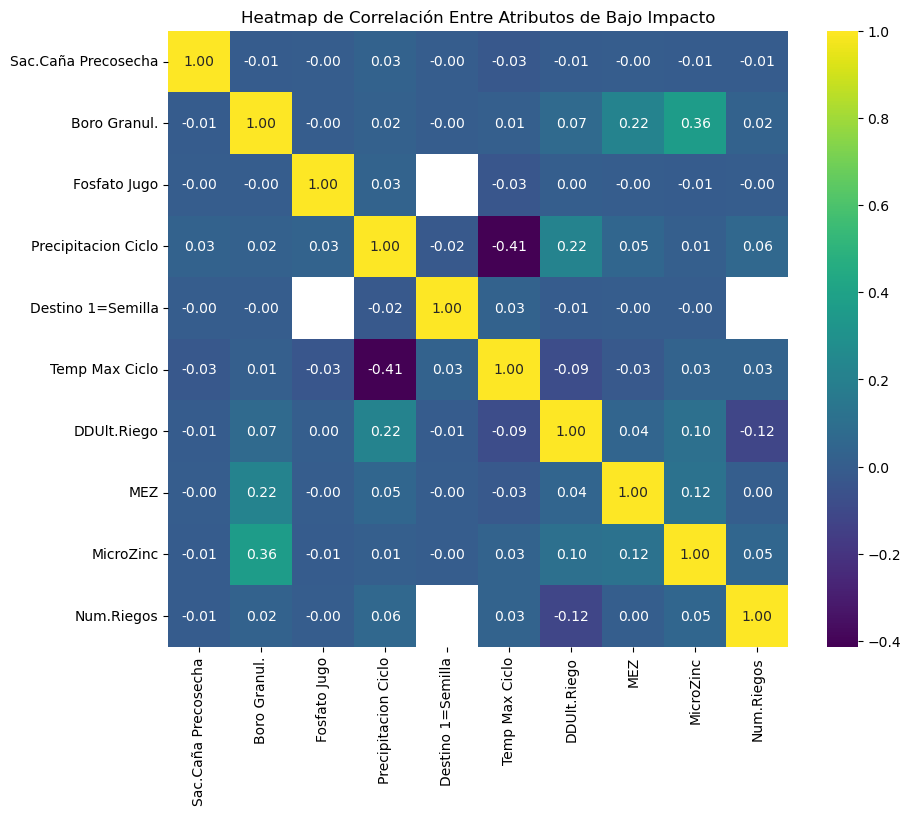

In [16]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# --- 1. Identificar variables con baja correlación a los objetivos ---
numeric_df_low_corr = df.select_dtypes(include=np.number)
corr_with_targets = numeric_df_low_corr.corr()[['TCH', '%Sac.Caña']].abs()

# Sumamos la correlación absoluta a ambos targets para tener un ranking de 'impacto'
corr_with_targets['total_corr'] = corr_with_targets['TCH'] + corr_with_targets['%Sac.Caña']

# Excluimos las propias variables objetivo y las que ya sabemos son leaks o muy correlacionadas
vars_to_exclude = ['TCH', '%Sac.Caña', 'TonUltCorte', 'TCHM', 'Ton.Azucar', 'Rdto', 'TAH', 'TAHM', 'KATRHM', '%ATR', 'Pureza']
low_corr_vars = corr_with_targets.drop(vars_to_exclude, errors='ignore').sort_values('total_corr').head(10).index.tolist()

print(f"Variables con menor correlación absoluta a TCH y %Sac.Caña:\n{low_corr_vars}\n")

# --- 2. Heatmap de correlación ENTRE estas variables de bajo impacto ---
plt.figure(figsize=(10, 8))
sns.heatmap(df[low_corr_vars].corr(), annot=True, cmap='viridis', fmt=".2f")
plt.title('Heatmap de Correlación Entre Atributos de Bajo Impacto')
plt.show()

#### Análisis del Heatmap de Atributos de Baja Correlación

De este heatmap se pueden extraer las siguientes conclusiones clave:

* **Independencia General:** La mayoría de las variables muestran una correlación muy cercana a 0 entre sí. Esto es positivo, ya que sugiere que cada atributo aporta información única y no son redundantes entre ellos.

* **Relación Climática Inversa:** Se observa una correlación negativa moderada de **-0.41** entre `Precipitacion Ciclo` y `Temp Max Ciclo`. Este resultado es lógicamente coherente, ya que períodos con mayor precipitación suelen ser más nublados y, por lo tanto, registran temperaturas máximas más bajas.

* **Asociación de Micronutrientes:** Existe una correlación positiva débil a moderada entre los fertilizantes, especialmente entre `Boro Granul.` y `MicroZinc` (**0.36**), y en menor medida con `MEZ`. Esto podría indicar que estos insumos a menudo se aplican de manera conjunta como parte de un mismo paquete de fertilización.

Aunque estas variables tienen un bajo impacto directo sobre `TCH` y `%Sac.Caña`, no son completamente aleatorias y muestran algunas relaciones agronómicas y climáticas esperadas entre ellas, validando la consistencia de los datos.

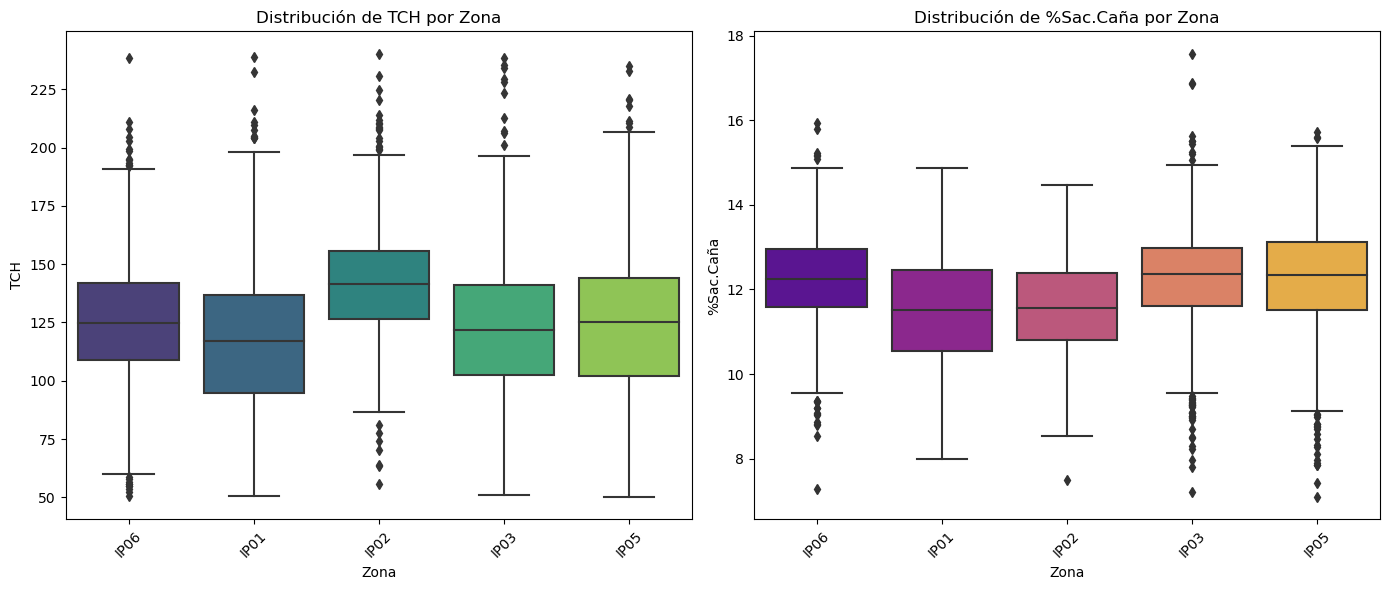

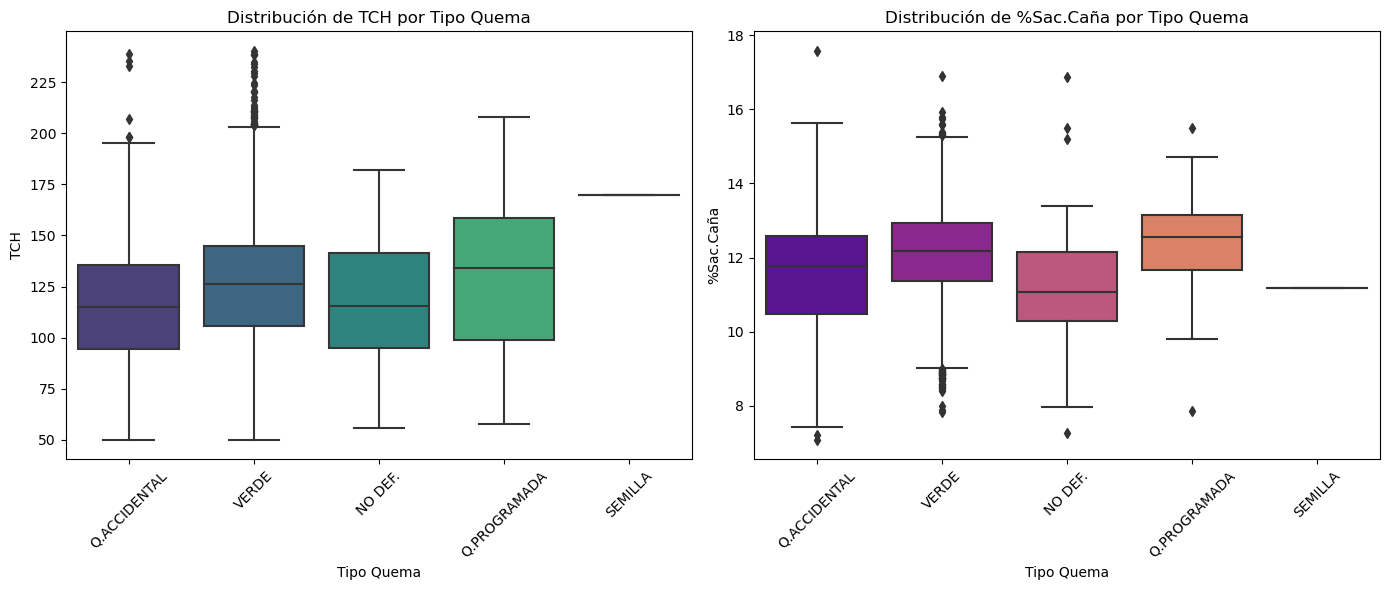

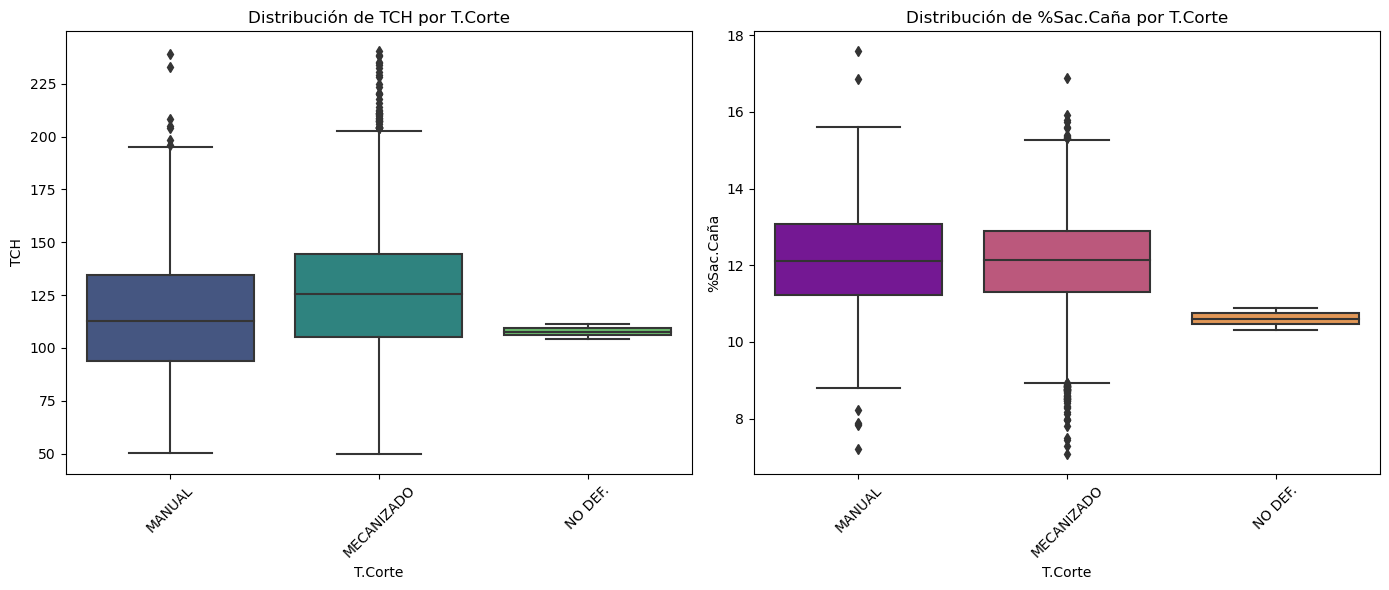


Generando Pair Plot para visualizar relaciones multivariadas...


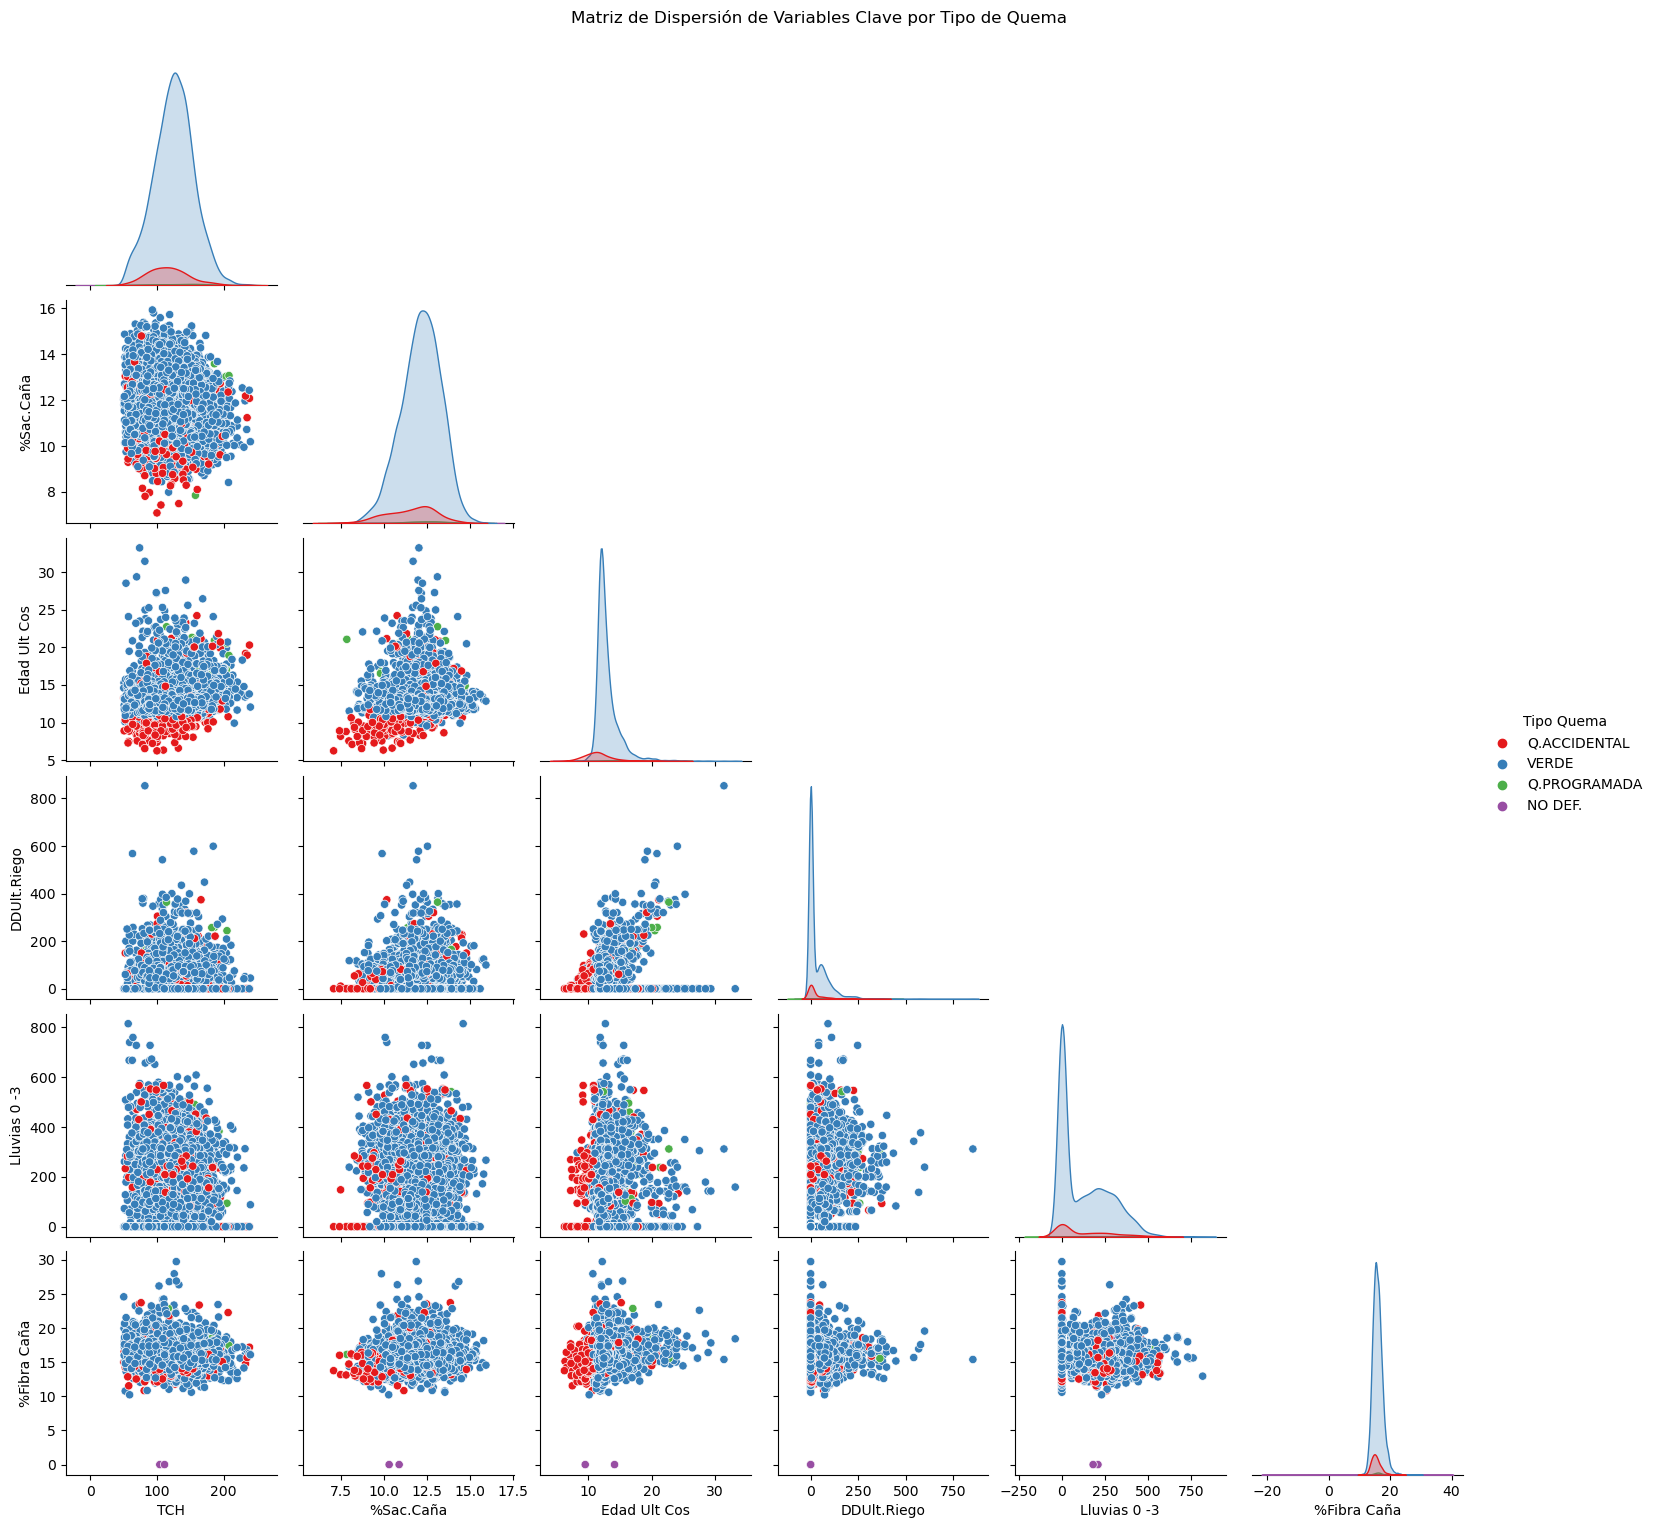

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

# --- 1. Análisis Univariado: Influencia de Variables Categóricas Clave ---

key_categorical_vars = ['Zona', 'Tipo Quema', 'T.Corte']

for var in key_categorical_vars:
    plt.figure(figsize=(14, 6))
    
    # Boxplot para TCH
    plt.subplot(1, 2, 1)
    sns.boxplot(x=var, y='TCH', data=df, palette='viridis')
    plt.title(f'Distribución de TCH por {var}')
    plt.xticks(rotation=45)
    
    # Boxplot para %Sac.Caña
    plt.subplot(1, 2, 2)
    sns.boxplot(x=var, y='%Sac.Caña', data=df, palette='plasma')
    plt.title(f'Distribución de %Sac.Caña por {var}')
    plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.show()

# --- 2. Análisis Multivariado: Matriz de Dispersión (Pair Plot) ---

# Seleccionamos un subconjunto de variables numéricas agronómicamente relevantes + los objetivos
# para evitar un gráfico demasiado grande y lento.
pairplot_vars = [
    'TCH',
    '%Sac.Caña',
    'Edad Ult Cos',
    'DDUlt.Riego',
    'Lluvias 0 -3',
    '%Fibra Caña'
]

print("\nGenerando Pair Plot para visualizar relaciones multivariadas...")
sns.pairplot(df[pairplot_vars + ['Tipo Quema']].dropna(), hue='Tipo Quema', palette='Set1', corner=True)
plt.suptitle('Matriz de Dispersión de Variables Clave por Tipo de Quema', y=1.02)
plt.show()

#### **Análisis Detallado de Visualizaciones Univariadas y Multivariadas**

#### 1. Influencia del Tipo de Corte (`T.Corte`)

Los box plots revelan cómo el método de cosecha se relaciona con el rendimiento y la calidad.

* **Rendimiento (TCH):**
    * El **corte MECANIZADO** presenta una mediana de `TCH` superior a la del corte `MANUAL`. Esto sugiere que, en promedio, la mecanización está asociada con mayores toneladas por hectárea.
    * Sin embargo, el corte `MECANIZADO` también muestra una mayor variabilidad (la "caja" es más alta), indicando que los resultados pueden ser más inconsistentes en comparación con el corte `MANUAL`.
* **Calidad (%Sac.Caña):**
    * La diferencia en la calidad de la sacarosa entre `MANUAL` y `MECANIZADO` es menos pronunciada. Sus medianas son muy similares y sus rangos intercuartílicos se solapan considerablemente.

#### 2. Influencia del Tipo de Quema (`Tipo Quema`)

El manejo de la quema antes de la cosecha es un factor crítico que afecta tanto al rendimiento como a la calidad.

* **Rendimiento (TCH):**
    * La **Quema Programada (`Q.PROGRAMADA`)** exhibe la mediana de `TCH` más alta, seguida de cerca por la cosecha en **Verde (`VERDE`)**.
    * La **Quema Accidental (`Q.ACCIDENTAL`)** y la categoría `NO DEF.` muestran rendimientos medianos inferiores, lo que es agronómicamente esperado, ya que una quema no controlada puede dañar la caña.
* **Calidad (%Sac.Caña):**
    * Aquí la diferencia es aún más marcada. La **`Q.PROGRAMADA`** y la cosecha en **`VERDE`** lideran claramente en contenido de sacarosa.

#### 3. Influencia de la Zona Geográfica (`Zona`)

La ubicación del lote de cultivo es otro factor determinante en los resultados de producción.

* **Rendimiento (TCH):**
    * Existe una variación clara en el rendimiento entre las zonas. Las zona **`IP02`**  destaca por tener la mediana de `TCH` más alta.
* **Calidad (%Sac.Caña):**
    * Interesantemente, la zona **`IP02`**, que tenía un alto rendimiento, muestra una calidad de sacarosa mediana más baja en comparación con otras zonas como `IP01`, `IP03` e `IP06`. Esto podría indicar un "trade-off" entre cantidad y calidad en esa zona específica.

#### 4. Análisis de Interacciones Multivariadas (Matriz de Dispersión)

El pair plot revela relaciones más complejas entre las variables numéricas clave, coloreadas por `Tipo Quema`.

* **Relación TCH vs. %Sac.Caña:** El gráfico de dispersión entre ambos objetivos muestra una "nube" de puntos sin una tendencia lineal clara. **Esto es un hallazgo crucial**: confirma que un mayor rendimiento no garantiza una mayor calidad, y viceversa. Por lo tanto, es correcto y necesario modelarlos como dos problemas de predicción separados.
* **Efecto de `Tipo Quema` en las Relaciones:** Al observar los colores, los puntos rojos (`Q.ACCIDENTAL`) parece que tienden a agruparse en las zonas de menor `%Sac.Caña`, independientemente de otras variables como la edad o las lluvias, reforzando la idea de que una quema accidental es un evento muy negativo para la calidad.

### Fase 5: Imputación de valores faltantes

**Objetivo:** garantizar un dataset sin valores nulos, aplicando diferentes estrategias según el tipo y la relevancia de cada variable.

---

#### 1) Eliminación por alta proporción de nulos
- **Eliminada:** `Sum Oscilacion Temp Ciclo`.  
*Motivo:* presenta más del 90% de valores faltantes y no existe una estrategia clara para su imputación.

---

#### 2) Imputación categórica
- **`Producto`** → valores faltantes reemplazados por `"SIN_PRODUCTO"`, representando lotes donde no se aplicó insumo.  
- **`Codigo Estacion`** → valores faltantes reemplazados por `"DESCONOCIDA"`, preservando el registro sin descartar la observación.

---

#### 3) Imputación numérica (KNN)
- Variables climáticas y agronómicas con valores faltantes (ej. `Num.Riegos`, `Temp. Media 0-3`, `%Fibra Caña`, `Vejez`, etc.) fueron imputadas mediante **KNN Imputer (k=5)**.  
*Motivo:* este método aprovecha la similitud entre registros cercanos para estimar valores faltantes de forma más coherente que una imputación simple (media o mediana).

---

**Resultado:** se obtuvo un dataset libre de nulos, manteniendo las variables relevantes y evitando eliminar registros de forma innecesaria.


In [18]:
# ---------- 1) Eliminar columnas con más del 90% de nulos ----------
threshold = 0.9 * len(df)
cols_high_null = [col for col in df.columns if df[col].isna().sum() >= threshold]
df = df.drop(columns=cols_high_null)
print("Columnas eliminadas por >90% nulos:", cols_high_null)

# ---------- 2) Imputar categóricas ----------
# Producto: imputar con categoría 'SIN_PRODUCTO'
if "Producto" in df.columns:
    df["Producto"] = df["Producto"].fillna("SIN_PRODUCTO")

# Codigo Estacion: imputar con categoría 'DESCONOCIDA'
if "Codigo Estacion" in df.columns:
    df["Codigo Estacion"] = df["Codigo Estacion"].fillna("DESCONOCIDA")

# ---------- 3) Imputar numéricas con KNN ----------
# Seleccionar solo columnas numéricas
numeric_cols = df.select_dtypes(include=["number"]).columns

# Guardar índices de nulos antes
null_counts_before = df[numeric_cols].isna().sum()

# Aplicar KNNImputer
imputer = KNNImputer(n_neighbors=5)
df[numeric_cols] = imputer.fit_transform(df[numeric_cols])

# Verificar nulos después
null_counts_after = df[numeric_cols].isna().sum()

print("\nNulos antes de imputación numérica:")
print(null_counts_before[null_counts_before > 0])
print("\nNulos después de imputación numérica:")
print(null_counts_after[null_counts_after > 0])


Columnas eliminadas por >90% nulos: ['Sum Oscilacion Temp Ciclo']

Nulos antes de imputación numérica:
Cod. T.Cultivo                2
Sac.Caña Precosecha         256
%Fibra Caña                 431
%AR Jugo                    433
%ME Min                     314
%ME Veg                     314
%ME Tot                     314
Vejez                       317
Num.Riegos                 4322
Fosfato Jugo                431
Temp. Media 0-3            2451
Temp. Media Ciclo          2451
Temp Max Ciclo             2451
Temp Min Ciclo             2451
Humedad Rel Media 0-3      2451
Oscilacion Temp Med 0-3    2451
Radiacion Solar Ciclo      2451
Precipitacion 0_3          2451
Precipitacion Ciclo        2451
Evaporacion 0-3            2451
Evaporacion Ciclo          2451
dtype: int64

Nulos después de imputación numérica:
Series([], dtype: int64)


### Fase 6: Pasos finales de limpieza y preparación

**Objetivo:** generar un dataset limpio, sin duplicados y con variables categóricas convertidas a formato numérico, listo para dividir en entrenamiento y prueba.

---

#### 1) Eliminación de duplicados
- Se eliminaron registros repetidos en el dataframe completo.  
- Esto asegura consistencia y evita que los modelos sobreestimen métricas al entrenar sobre datos idénticos.

---

#### 2) Codificación de variables categóricas
- Se identificaron variables tipo *object* (`Producto`, `Codigo Estacion`, `Zona`, `Variedad`, `Tipo Quema`, `T.Corte`, `Cerca de`, `Cosechó`, etc.).  
- Se aplicó **one-hot encoding** con `drop_first=True`, generando variables binarias (0/1) y reduciendo el riesgo de multicolinealidad.  
- Las variables objetivo (`TCH`, `%Sac.Caña`) no fueron codificadas.

---

#### 3) Exportación del dataset final
- El dataframe resultante se guardó en **`data/HISTORICO_SUERTES_cleaned.csv`**.  
- Este archivo constituye la base de datos limpia y lista para la fase de modelado, donde se aplicará escalado de numéricas después de separar en conjuntos de entrenamiento y prueba.

---

**Resultado:** dataset limpio, sin duplicados, categóricas codificadas y preparado para la siguiente fase de modelado.


In [19]:
# ---------- 1) Eliminar duplicados ----------
print("Previo a eliminar duplicados:", df.shape)
df = df.drop_duplicates()
print("Duplicados eliminados. Shape actual:", df.shape)

# ---------- 2) One-hot encoding ----------
# Detectar variables categóricas tipo object
categorical_cols = df.select_dtypes(include=["object"]).columns.tolist()

# Quitamos las variables objetivo de esa lista por seguridad
categorical_cols = [col for col in categorical_cols if col not in ["TCH", "%Sac.Caña"]]

print("Variables categóricas a codificar:", categorical_cols)

# One-hot encoding con drop_first para evitar multicolinealidad
# dtype=int asegura que las columnas queden como 0/1 y no como boolean
df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True, dtype=int)

# ---------- 3) Guardar CSV ----------
output_path = "data/HISTORICO_SUERTES_cleaned.csv"
df_encoded.to_csv(output_path, index=False)

print("Archivo guardado en:", output_path)
print("Shape final del dataframe:", df_encoded.shape)


Previo a eliminar duplicados: (6785, 52)
Duplicados eliminados. Shape actual: (6785, 52)
Variables categóricas a codificar: ['Zona', 'Variedad', 'Producto', 'Tipo Quema', 'T.Corte', 'Codigo Estacion']
Archivo guardado en: data/HISTORICO_SUERTES_cleaned.csv
Shape final del dataframe: (6785, 122)
